###With great **flexibility** comes great **overfitting**


**What is overfitting?**

  Overfitting is when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. This means that the noise or random fluctuations in the training data is picked up and learned as concepts by the model.


In [2]:
    !pip install category_encoders==2.*
    !pip install pandas_profiling==2.*

     |████████████████████████████████| 81kB 3.6MB/s 
     |████████████████████████████████| 245kB 5.4MB/s 
     |████████████████████████████████| 1.1MB 11.1MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 
     |████████████████████████████████| 3.1MB 21.9MB/s 
     |████████████████████████████████| 112kB 30.0MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 296kB 32.7MB/s 
  Created wheel for phik: filename=phik-0.11.2-cp37-none-any.whl size=1107437 sha256=43e8efddc739b7a0e7901524b8c47c6561b5719dbe8406a4e722e963924d0121
  Stored in directory: /root/.cache/pip/wheels/c0/a3/b0/f27b1cfe32ea131a3715169132ff6d85653789e80e966c3bf6
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27099 sha256=e1e9dee1763dcada00abea77db8b0a2923a49d61ac9b9dc052bbceba1a3518f9
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
Successfully built phik htmlmin
ERROR: go

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


pd.options.display.max_rows = 100

# Decision Trees

- clean data with **outliers and missing values**
- use scikit-learn for **decision trees**
- get and interpret **feature importances** of a tree-based model
- understand why decision trees are useful to model 

# I. Wrangle Data

### Import data



In [56]:
# train_features and train_labels
train_features = pd.read_csv('train_features.csv')

print(train_features.shape)
train_features.head()

(47520, 40)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,454,50.0,2013-02-27,Dmdd,2092,DMDD,35.426020,-4.227446,Narmo,0,Internal,Bashnet Kati,Manyara,21,1,Babati,Bashinet,160,True,GeoData Consultants Ltd,Water Board,NaN,True,1998,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
1,510,0.0,2011-03-17,Cmsr,0,Gove,35.510074,-5.724555,Lukali,0,Internal,Lukali,Dodoma,1,6,Bahi,Lamaiti,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
2,14146,0.0,2011-07-10,Kkkt,0,KKKT,32.499866,-9.081222,Mahakama,0,Lake Rukwa,Chawalikozi,Mbeya,12,6,Mbozi,Ndalambo,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
3,47410,0.0,2011-04-12,NaN,0,NaN,34.060484,-8.830208,Shule Ya Msingi Chosi A,0,Rufiji,Shuleni,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
4,1288,300.0,2011-04-05,Ki,1023,Ki,37.032690,-6.040787,Kwa Mjowe,0,Wami / Ruvu,Ngholong,Morogoro,5,1,Kilosa,Chakwale,120,True,GeoData Consultants Ltd,VWC,NaN,True,1997,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other


In [57]:
test_features = pd.read_csv('test_features.csv')

print(test_features.shape)
test_features.head()

(11880, 40)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,37098,0.0,2012-10-09,Rural Water Supply And Sanitat,0,DWE,31.985658,-3.596360,Kasela,0,Lake Tanganyika,Bufanka Centre,Shinyanga,17,5,Bukombe,Iyogela,0,True,GeoData Consultants Ltd,WUG,NaN,True,0,other,other,other,wug,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
1,14530,0.0,2012-11-03,Halmashauri Ya Manispa Tabora,0,Halmashauri ya manispa tabora,32.832815,-4.944937,Mbugani,0,Lake Tanganyika,Maendeleo,Tabora,14,6,Tabora Urban,Uyui,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,milky,milky,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
2,62607,10.0,2013-02-25,Siter Fransis,1675,DWE,35.488289,-4.242048,Kwa Leosi,0,Internal,Qatabradiki,Manyara,21,1,Babati,Dareda,148,True,GeoData Consultants Ltd,Water Board,NaN,True,2008,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
3,46053,0.0,2011-08-13,Kkkt,0,KKKT,33.140828,-9.059386,Jangi,0,Lake Rukwa,Chawama,Mbeya,12,6,Mbozi,Iyula,0,False,GeoData Consultants Ltd,VWC,NaN,False,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,seasonal,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump
4,47083,50.0,2013-02-08,Wateraid,1109,SEMA,34.217077,-4.430529,Mkima,0,Internal,Mkima,Singida,13,1,Iramba,Mtoa,235,True,GeoData Consultants Ltd,WUA,Tyeme water supply,True,2011,mono,mono,motorpump,wua,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe


In [58]:
train_labels = pd.read_csv('train_labels.csv')

print(train_labels.shape)
train_labels.head()

(47520, 2)


,id,status_group
0,454,functional
1,510,functional
2,14146,non functional
3,47410,non functional
4,1288,non functional


In [88]:
train_features = pd.read_csv('train_features.csv',na_values=[0,-2.0e-08]) #na_values=[0,-2.0e-08] replaces 0 and -2.0e-08 with NaN
train_labels = pd.read_csv('train_labels.csv',na_values=[0,-2.0e-08]) #this could be good or bad depending on the column

#training set
train_df = pd.merge(train_labels,train_features,on = 'id')


def wrangle(df):
  
  # Set the index to 'id'
  df.set_index('id', inplace = True)

  # Drop constant column
  df.drop(columns = ['recorded_by'],inplace = True)

  # Drop duplicate columns
  df.drop(columns = ['quantity_group'],inplace = True)

  # Drop high cardinality columns 
  print([col for col in train_df.select_dtypes('object') if train_df[col].nunique() > 100])
  df.drop(columns = [col for col in df.select_dtypes('object') if df[col].nunique() > 100],inplace = True)

  # Drop high proportion of null value columns
  print([col for col in train_df if train_df[col].isnull().sum() * 100 / len(train_df[col]) > 95])
  df.drop(columns = [col for col in df if df[col].isnull().sum() * 100 / len(df[col]) > 95], inplace = True)
 
  return df

wrangle(train_df)

['date_recorded', 'funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name']
['num_private']


,status_group,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
454.0,functional,50.0,2092.0,35.426020,-4.227446,Internal,Manyara,21,1.0,160.0,True,Water Board,True,1998.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
510.0,functional,NaN,NaN,35.510074,-5.724555,Internal,Dodoma,1,6.0,NaN,True,VWC,True,NaN,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump
14146.0,non functional,NaN,NaN,32.499866,-9.081222,Lake Rukwa,Mbeya,12,6.0,NaN,True,VWC,False,NaN,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other
47410.0,non functional,NaN,NaN,34.060484,-8.830208,Rufiji,Mbeya,12,7.0,NaN,True,VWC,True,NaN,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
1288.0,non functional,300.0,1023.0,37.032690,-6.040787,Wami / Ruvu,Morogoro,5,1.0,120.0,True,VWC,True,1997.0,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,shallow well,shallow well,groundwater,other,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68525.0,functional,1000.0,327.0,36.367112,-8.774761,Rufiji,Morogoro,5,4.0,255.0,True,Water Board,True,1995.0,gravity,gravity,gravity,wug,user-group,pay monthly,monthly,soft,good,enough,river,river/lake,surface,communal standpipe,communal standpipe
11980.0,functional,1000.0,1743.0,34.531524,-9.769604,Lake Nyasa,Iringa,11,5.0,35.0,True,VWC,False,1988.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,seasonal,spring,spring,groundwater,communal standpipe,communal standpipe
35778.0,non functional,NaN,-13.0,38.974416,-5.420823,Pangani,Tanga,4,5.0,1000.0,False,Private operator,False,2005.0,other,other,other,private operator,commercial,never pay,never pay,soft,good,insufficient,shallow well,shallow well,groundwater,other,other


### EDA

Here we do all the EDA, so then we can modify the wrangle df above

####PandaProfiling - New Tool

In [76]:
#NEW TOOL - PandaProfiling
Report = ProfileReport(train_df,minimal= True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

####Columns with High or Low Cardinality?

In [77]:
train_df.isnull().sum().sort_values(ascending = False)


district_code            19
waterpoint_type_group     0
waterpoint_type           0
basin                     0
region                    0
region_code               0
extraction_type           0
extraction_type_group     0
extraction_type_class     0
management                0
management_group          0
payment                   0
payment_type              0
water_quality             0
quality_group             0
quantity                  0
source                    0
source_type               0
source_class              0
status_group              0
dtype: int64

In [78]:
#High Cardinality
[col for col in train_df.select_dtypes('object') if train_df[col].nunique() > 100]

[]

####Nulls

In [79]:
#High percentage of nulls
[col for col in train_df if train_df[col].isnull().sum() * 100 / len(train_df[col]) > .90]

[]

####Repeat Columns?

In [80]:
# Do we have any repeat columns?
# train_df.head(10).T.duplicated() #checking within the first 10 rows
train_df.head(100).T.duplicated() #checking within the first 100 rows

# Are they exactly the same?
np.array_equal(train_df['quantity_group'], train_df['quantity'])

KeyError: ignored

####Zeros that should be Nulls

In [89]:
train_df.head()

,status_group,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
454.0,functional,50.0,2092.0,35.426020,-4.227446,Internal,Manyara,21,1.0,160.0,True,Water Board,True,1998.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
510.0,functional,NaN,NaN,35.510074,-5.724555,Internal,Dodoma,1,6.0,NaN,True,VWC,True,NaN,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump
14146.0,non functional,NaN,NaN,32.499866,-9.081222,Lake Rukwa,Mbeya,12,6.0,NaN,True,VWC,False,NaN,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other
47410.0,non functional,NaN,NaN,34.060484,-8.830208,Rufiji,Mbeya,12,7.0,NaN,True,VWC,True,NaN,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
1288.0,non functional,300.0,1023.0,37.032690,-6.040787,Wami / Ruvu,Morogoro,5,1.0,120.0,True,VWC,True,1997.0,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,shallow well,shallow well,groundwater,other,other


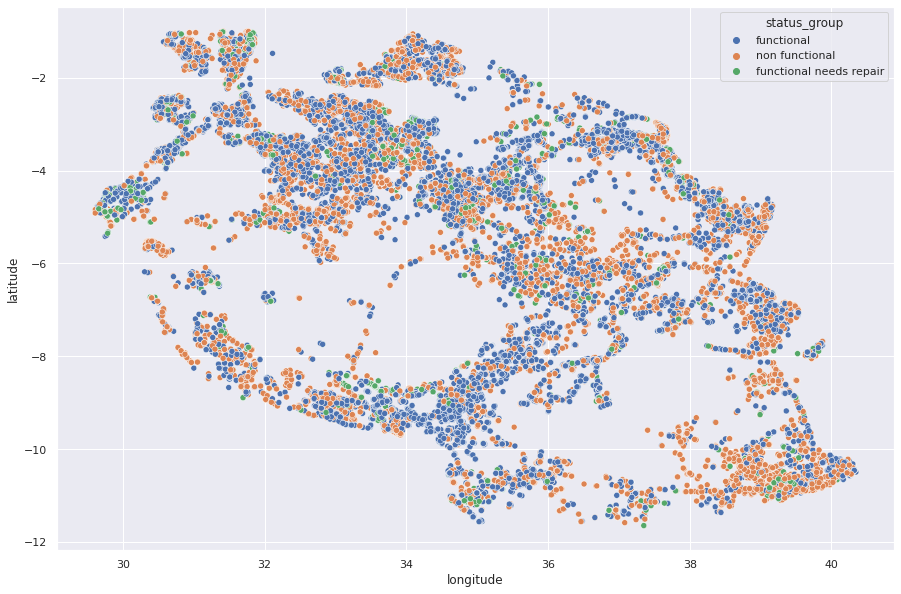

In [96]:
# plt.scatter(train_df['longitude'],train_df['latitude'])
# plt.show()

sns.set(rc = {'figure.figsize':(15,10)})

sns.scatterplot(x = 'longitude', y = 'latitude', data = train_df, hue = 'status_group')

plt.show()

# II. Split Data

## Split TV from FM

In [99]:
target = 'status_group'
y = train_df[target]
X = train_df.drop(columns = target)

## Training-Validation Split

In [111]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = .2, random_state = 42)

# III. Establish Baseline

- Is this a *regression* or a *classification* problem?

In [112]:
# Baseline predict 'functional' for all pumps
#  should give 54%
print(f'Baseline predict "functional" for all pumps: {y_train.value_counts(normalize=True).max()}')

Baseline predict "functional" for all pumps: 0.5440867003367004


# IV. Build Model(s)

- Encoder for categorical features.
- Imputer for missing values.
- `StandardScaler` for `LogisticRegression`

**First Model:** Logistic Regression

max_inter = 100 causes up the model to Stop

In [113]:
model_lr = make_pipeline(OneHotEncoder(use_cat_names=True),
                         SimpleImputer(strategy='mean'),
                         StandardScaler(),
                         LogisticRegression(max_iter = 200)
                         )

model_lr.fit(X_train,y_train)

#STOP: TOTAL NO. of ITERATIONS REACHED LIMIT at max_iter = 100


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['basin', 'region', 'public_meeting',
                                     'scheme_management', 'permit',
                                     'extraction_type', 'extraction_type_group',
                                     'extraction_type_class', 'management',
                                     'management_group', 'payment',
                                     'payment_type', 'water_quality',
                                     'quality_group', 'quantity', 'source',
                                     'source_type', 'source_class',
                                     'waterpoint_type',...
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    

**Second Model:** Decision Tree Classifier

In [139]:
model_dt = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy='mean'),
                         DecisionTreeClassifier(random_state=42, max_depth=16) #Setting a max_depth can help with overfitting
                         )

model_dt.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type...
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                             

**Interlude: How does a tree model work?**

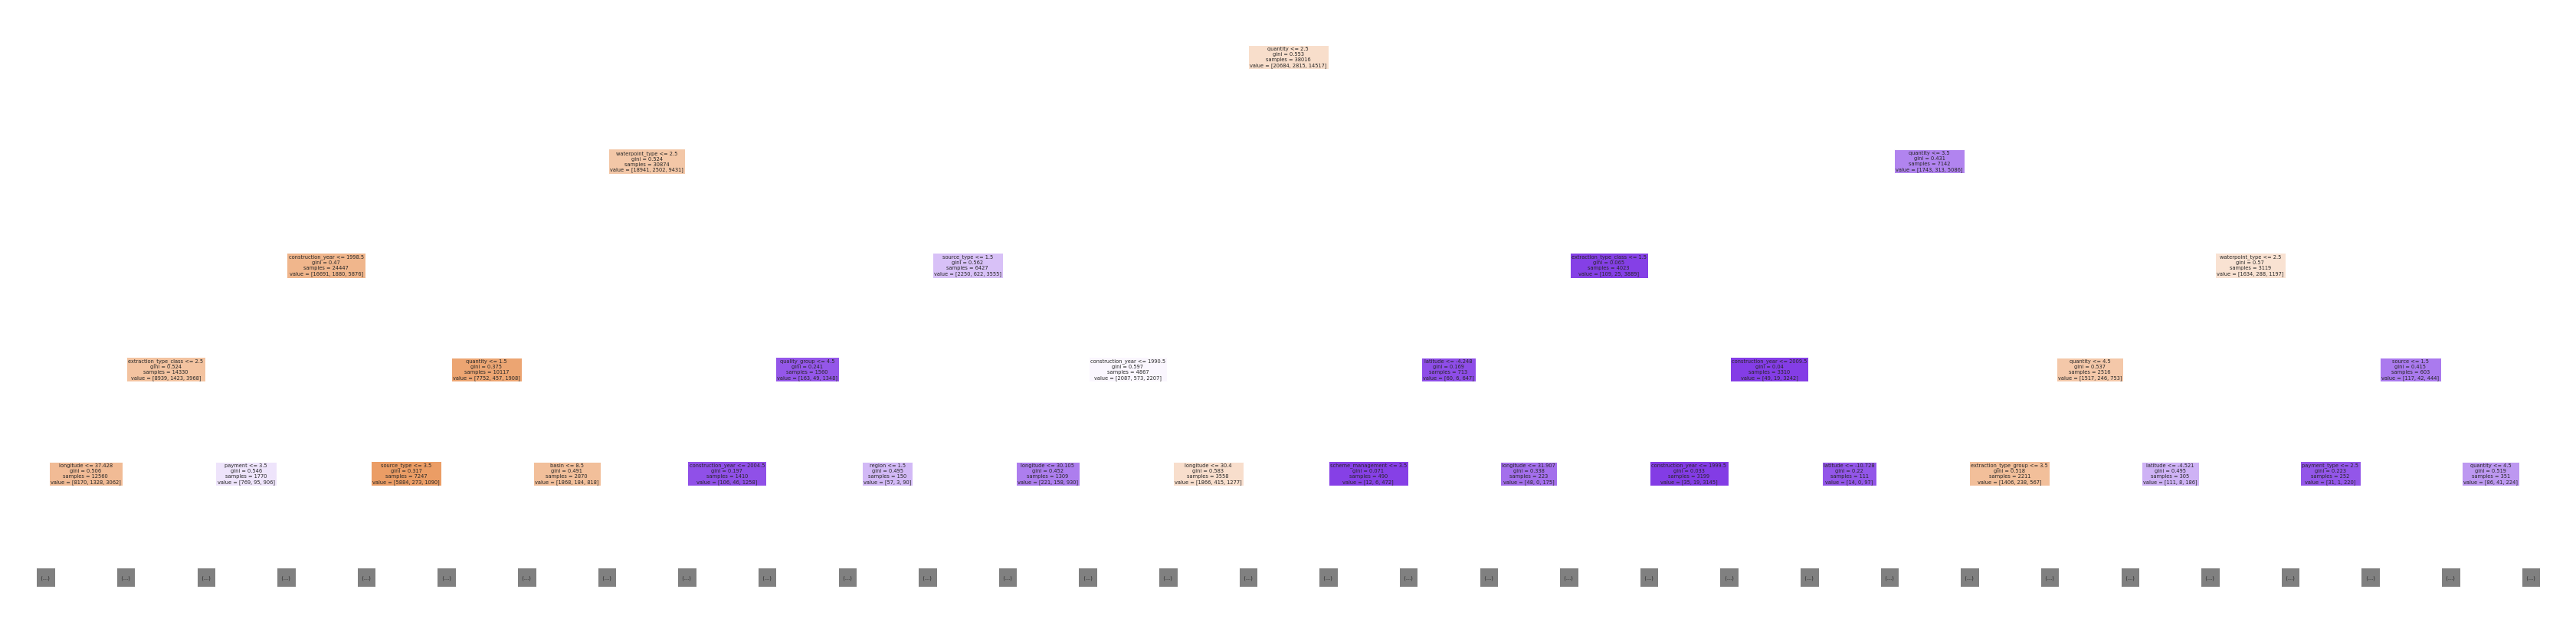

In [140]:
plt.figure(figsize=(60,15))
plot_tree(model_dt.named_steps['decisiontreeclassifier'],
          max_depth=4,
          feature_names=X_train.columns,
          filled=True);

In [141]:
# !pip install dtreeviz

In [142]:
# from dtreeviz.trees import dtreeviz # remember to load the package

# viz = dtreeviz(model_dt, X_train, y_train,
#                 target_name=target,
#                 feature_names=X.columns,
#                 class_names=['functional', 'needs repair', 'non-functional'])

# viz

# V. Check Metrics

###Is our Logistic Regression Model better after the baseline?

In [143]:
print('model_lr accuracy score for training:', accuracy_score(y_train, model_lr.predict(X_train)))
print('model_lr accuracy score for val:', accuracy_score(y_val, model_lr.predict(X_val)))

model_lr accuracy score for training: 0.7366109006734006
model_lr accuracy score for val: 0.7447390572390572


Yes!

###Is our Decision Tree Model better than the Logistic Regression?

**First Attempt with Max depth = None**
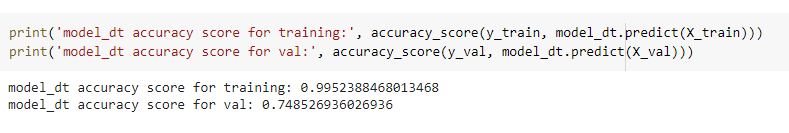

Yes! BUT a lot of overfitting


**Second Attempt with max_depth = 5**

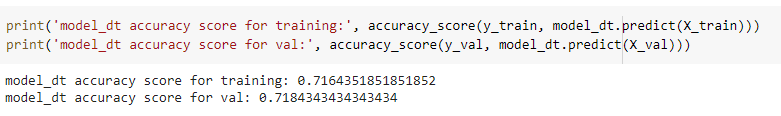

**Third Attempt with max_depth = 16**

In [144]:
print('model_dt accuracy score for training:', accuracy_score(y_train, model_dt.predict(X_train)))
print('model_dt accuracy score for val:', accuracy_score(y_val, model_dt.predict(X_val)))

model_dt accuracy score for training: 0.8776304713804713
model_dt accuracy score for val: 0.7631523569023569


###Overfit the training data, but is better than the logistic model

In [145]:
print('model_dt accuracy score for training', accuracy_score(y_train, model_dt_or.predict(X_train)))
print('model_dt accuracy score for val', accuracy_score(y_val, model_dt_or.predict(X_val)))

NameError: ignored

###Is our better than the Decision Tree Model?

# VI. Tune Model

Let's look at the hyperparameter `max_depth`

In [ ]:
train_acc = []
val_acc = []
for depth in range(2,38,2):
  tree_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      DecisionTreeClassifier(max_depth = depth, random_state=42)
  )
  tree_model.fit(X_train,y_train)
  train_acc.append(tree_model.score(X_train,y_train))
  val_acc.append(tree_model.score(X_val,y_val))


Overfitting in practice

In [ ]:
plt.plot(range(2,38,2),train_acc, color = 'blue', label='trianing')
plt.plot(range(2,38,2),val_acc, color = 'yellow', label='trianing')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# VII. Communicate Results


### Gini importance

Text(0.5, 0, 'gini importance')

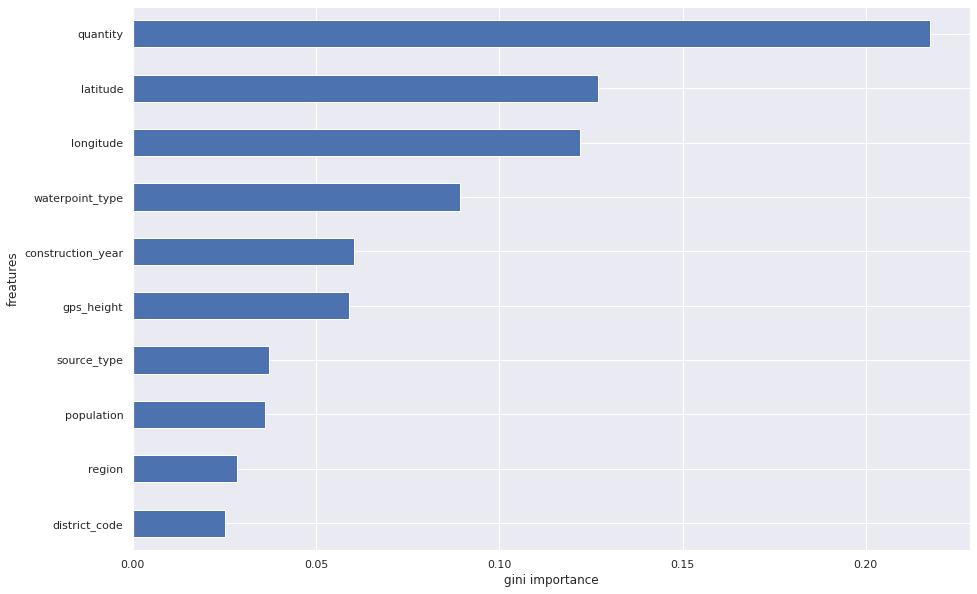

In [149]:
features = model_dt.named_steps['ordinalencoder'].get_feature_names()
gini = model_dt.named_steps['decisiontreeclassifier'].feature_importances_

pd.Series(data = gini, index = features).sort_values(key = abs).tail(10).plot(kind = 'barh')
plt.ylabel('freatures')
plt.xlabel('gini importance')

####Sample Submission


In [153]:
sample_submission = pd.read_csv('sample_submission.csv')

sample_submission.head()

,id,status_group
0,37098,functional
1,14530,functional
2,62607,functional
3,46053,functional
4,47083,functional


In [155]:
# generate sample sumbmission
sample_submission.to_csv('sample_submission.csv', index = False)

In [158]:
#download 
from google.colab import files
files.download('sample_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

####Real Submission

In [160]:
model_lr.predict(X_val)

predictions = pd.DataFrame(data=model_lr.predict(X_val), index=X_val.index)

predictions.columns = ['status_group']

predictions.head()

,status_group
id,
20217.0,functional
67143.0,functional
2948.0,functional
40301.0,functional
61519.0,functional


In [161]:
# generate CSV
predictions.to_csv('new_submission.csv')

In [162]:
# download
from google.colab import files
files.download("new_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>